In [1]:
%%time 
# import libraries
import os
import io
import subprocess

import PIL

import sagemaker
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import RealTimePredictor, json_deserializer

from fastai.vision import *

CPU times: user 1.07 s, sys: 104 ms, total: 1.18 s
Wall time: 1.2 s


The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the sagemaker.get_execution_role() with appropriate full IAM role arn string(s).

In [2]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/champipi-model'

role = sagemaker.get_execution_role()


In [3]:

#path_img = path/'images'

#fnames = get_image_files(path_img+'cepes')
#fnames[:5]

Upload the data
We use the sagemaker.Session.upload_data function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use this later when we start the training job.

In [ ]:
inputs = sagemaker_session.upload_data(path=path_img, bucket=bucket, key_prefix=prefix)
print('input spec (in this case, just an S3 path): {}'.format(inputs))

In [4]:
!pygmentize champi.py

import argparse
import logging
import sagemaker_containers
import requests

import os
import io
import glob
import time

from fastai.vision import *

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# set the constants for the content types
JSON_CONTENT_TYPE = 'application/json'
JPEG_CONTENT_TYPE = 'image/jpeg'

def _train(args):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    logger.info("Device Type: {}".format(device))

    logger.info("Loading Mushrooms dataset")
    print(f'Batch size: {args.batch_size}')
    path = Path(args.data_dir)
    print(f'Data path is: {path}')
    path_img = path/'images'
    folders = ['cepes','chanterelles_trompettes_girolles', 'oronges', 'pied_moutons', 'sanguins','veneneux']
    classes = ['cepes', 'chanterelles_trompettes_girolles', 'oronges', 'pied_moutons', 'sanguins','veneneux']
    #fnames = get_image_files(path_img)
    
    # get the pattern to select the training/validation data
    np.random.seed(42)
    d

In [5]:
# Comment out all lines below if not training locally
#data_location='file://'+str(path_img)
instance_type = 'local'
#if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    #instance_type = 'local_gpu'
    
# Comment out all lines below if not training on SageMaker
data_location='s3://sagemaker-eu-west-3-164476836539/sagemaker/champipi-model'
#instance_type = 'ml.m5.xlarge'

In [ ]:
#%%bash
#!wget -N https://download.pytorch.org/models/resnet34-333f7ec4.pth

#pip install nvidia-ml-py3
#pip install sagemaker 


In [13]:
# Train my estimator
champi_estimator = PyTorch(entry_point='champi.py',#train the model
                         base_job_name='fastai-champi',
                         role=role,
                         framework_version='1.0.0',
                         train_instance_count=1,
                         train_instance_type=instance_type)#'ml.m5.xlarge'

champi_estimator.fit(data_location)

Creating tmpdbve5f94_algo-1-alsxl_1 ... 
Attaching to tmpdbve5f94_algo-1-alsxl_12mdone
algo-1-alsxl_1  | 2020-01-21 21:08:56,379 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
algo-1-alsxl_1  | 2020-01-21 21:08:56,382 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-alsxl_1  | 2020-01-21 21:08:56,391 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
algo-1-alsxl_1  | 2020-01-21 21:08:56,392 sagemaker_pytorch_container.training INFO     Invoking user training script.
algo-1-alsxl_1  | 2020-01-21 21:08:56,485 sagemaker-containers INFO     Module champi does not provide a setup.py. 
algo-1-alsxl_1  | Generating setup.py
algo-1-alsxl_1  | 2020-01-21 21:08:56,485 sagemaker-containers INFO     Generating setup.cfg
algo-1-alsxl_1  | 2020-01-21 21:08:56,485 sagemaker-containers INFO     Generating MANIFEST.in
algo-1-alsxl_1  | 2020-01-21 21:08:56,485 sagemaker-containers INFO     Ins

1         0.291103    0.324801    0.111675       
2         0.261298    0.313994    0.096447       
algo-1-alsxl_1  | Finished Training
algo-1-alsxl_1  | Export data object
algo-1-alsxl_1  | Saving model weights
algo-1-alsxl_1  | 2020-01-21 21:41:56,509 sagemaker-containers INFO     Reporting training SUCCESS
tmpdbve5f94_algo-1-alsxl_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


# Deploy the trained model to prepare for predictions
First we need to create a PyTorchModel object from the estimator. The deploy() method on the model object creates an endpoint (in this case locally) which serves prediction requests in real-time. If the instance_type is set to a SageMaker instance type (e.g. ml.m5.large) then the model will be deployed on SageMaker. If the instance_type parameter is set to local then it will be deployed locally as a Docker container and ready for testing locally.

First we need to create a RealTimePredictor class to accept jpeg images as input and output JSON. The default behaviour is to accept a numpy array.

In [14]:
from sagemaker.predictor import RealTimePredictor, json_deserializer
#deploy to sageMaker
class ImagePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=None, deserializer=json_deserializer, content_type='image/jpeg')

In [15]:
champi_model=PyTorchModel(model_data=champi_estimator.model_data,
                        name=champi_estimator._current_job_name,
                        role=role,
                        framework_version=champi_estimator.framework_version,
                        entry_point=champi_estimator.entry_point,
                        predictor_cls=ImagePredictor)

champi_predictor = champi_model.deploy(initial_instance_count=1,instance_type='ml.m5.xlarge')

---------------------------------------------------------------!

# Invoking the endpoint


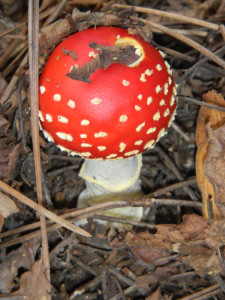

In [42]:
url = 'http://img.over-blog.com/225x300/5/68/68/80/Les-champignons/Amanite-tue-mouches--7-.JPG'
img_bytes = requests.get(url).content

img = PIL.Image.open(io.BytesIO(img_bytes))
img

In [43]:
response = champi_predictor.predict(img_bytes)
response

{'class': 'veneneux', 'confidence': 0.8374230265617371}

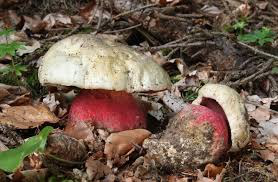

In [111]:
#open jpg images for predictions

path2 = Path('tel')

img_bytes=open(path2/'satan.jpg', 'rb').read()
img1=PIL.Image.open(io.BytesIO(img_bytes))

img1

In [112]:
response1 = champi_predictor.predict(img_bytes)
response1

{'class': 'veneneux', 'confidence': 0.9915004968643188}

In [67]:
from pathlib import Path

datadir=Path('tel/')
test = ImageDataBunch.from_folder(datadir,
                                  test='test',
                                  valid_pct=0,
                                  seed=42,
                                  bs=32,
                                  ds_tfms=get_transforms(), 
                                  size=47).normalize(imagenet_stats)
#test

path3 = Path('tel/')
#pred=[]
for i in range(0,46):
    #if i.endswith(".jpg"):
    #p = learn.predict(test.x[i]) 
    y=[x for x in path3.iterdir() ]
    print(y[i])
    #print(str(p[0]))
print(champi_predictor.predict(test.x[i]) )


tel/cep.jpeg
tel/tromp.jpg
tel/sangui-gri.jpg
tel/mout1.jpg
tel/goodcep.jpg
tel/bad1.jpg
tel/oronge.jpg
tel/trompet.jpg
tel/cep3.jpg
tel/chanter.jpg
tel/cepe.jpg
tel/wrg.jpg
tel/wrgsangui.jpg
tel/cep1.jpg
tel/cep5.jpg
tel/chant.jpg
tel/sangui.jpg
tel/bad.jpg
tel/tromette.jpg
tel/amanite mouche.jpg
tel/cepos.jpg
tel/chnt.jpg
tel/bolet.jpg
tel/giro.jpg
tel/goodcep1.jpg
tel/wrong.jpg
tel/petit gris.jpg
tel/iop.jpg
tel/mov.jpg
tel/wrgsangui2.jpg
tel/ro.jpeg
tel/satan.jpg
tel/tromp-autre.jpeg
tel/wrg3.jpg
tel/cep-tromp.jpg
tel/gir.jpg
tel/mauvais.jpg
tel/trompet.jpeg
tel/cep4.jpg
tel/wrg1.jpg
tel/bad2.jpg
tel/bad-tromp.jpg
tel/cep.jpg
tel/mouton.jpg
tel/cep2.jpg
tel/oronge-cep.jpg


ParamValidationError: Parameter validation failed:
Invalid type for parameter Body, value: Image (3, 1024, 768), type: <class 'fastai.vision.image.Image'>, valid types: <class 'bytes'>, <class 'bytearray'>, file-like object

# Clean-up
Deleting the local endpoint when you're finished is important since you can only run one local endpoint at a time.

In [ ]:
champi_estimator.delete_endpoint()